# FloyHub introduction to Deep Learning: Linear Regression

### Abstract
It’s Time to fire up the torch, we will cover the basic concept of ML to solve the hello world of ML: predict house estimation given square feet. Then we move on another classical: the handwritten digit recognition with Logistic Regression. *It’s ML time*.

## Introduction
We are going to solve an overly simple, and unrealistic problem, which has the upside of making understanding the concepts of ML and PyTorch easy. We want to predict a single scalar outcome, house price (in $) based on a single feature, house size (in square meters, sqm). This eradicates the need to handle multi-dimensional data, enabling us to focus solely on defining a model, implementing, and training it in PyTorch.

### Table of Contents

- ML Hello World
- Collect a Dataset
- Choose a Model (sub paraghaps)
- Train
- Evaluate
- Summary

## The ML Hello World

We start with a set of data points that we have collected (chart below), each representing the relationship between two values —an outcome (house price) and the influencing feature (house size).

![img - dataset](https://cdn-images-1.medium.com/max/1280/1*wcivD-w2dNHR7L3JUKwbhQ.png)

However, we cannot predict values for features that we don’t have data points for (chart below)

![img - how can we predict a new value given sqm](https://cdn-images-1.medium.com/max/1280/1*GH-vC3HDd01UFjjjCVMQlA.png)

We can use ML to discover the relationship (the ‘best-fit prediction line’ in the chart below), such that given a feature value that is not part of the data points, we can predict the outcome accurately (the intersection between the feature value and the prediction line.

![img - how can we predict a new value given sqm - visual solution](https://cdn-images-1.medium.com/max/1280/1*LMIk7UyRhz4ObI2FWX_75Q.png)

## Collect a Dataset

One of the most time and resource consuming task of every ML/DL workflow is to collect [high quality] dataset. What can we do? Well first of all you can Explore our datasets, otherwise you can search throught Internet. 
Luckily Kaggle has provided a great dataset of sold houses in King County from May 2014 to 2015, we have already uploaded it for you so that you can immediatly start to play.

Let’s take a look about this dataset:


In [28]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

cuda = torch.cuda.is_available()

In [47]:
# The dataset is mounted in the /input path
data = pd.read_csv("/input/kc_house_data.csv")
# Return the first n=5 rows
data.head(n=5)

print (data['price'][21414])
print (data['sqft_living'][21414])

557500.0
3350


In [7]:
# Describe our Dataset with some stats
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Our main focus is trying to predict the price given the squarefeet. (You are free to make experiment on the other features)

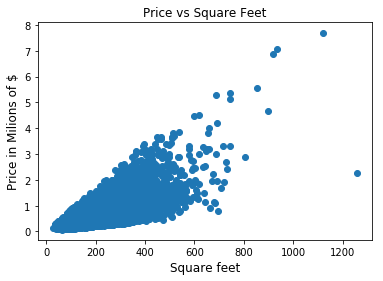

In [27]:
# Now let's plot Square Feet vs Price
# If you are European or want to reason in square meters: multiply sqft * 0.092903
plt.scatter(x=data.sqft_living, y=data.price/1e6)
plt.ylabel('Price in Milions of $', fontsize=12)
plt.xlabel('Square feet', fontsize=12)
plt.title("Price vs Square Feet")

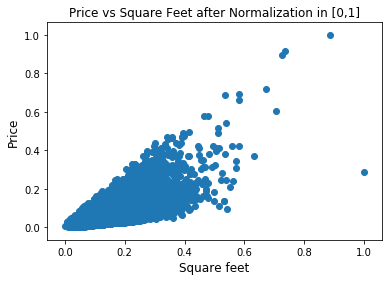

In [78]:
def dataset_normalization(ds):
    # Normalize data in [0,1] range
    # new_x = (x - min)/(max - min) 
    min = ds.min()
    max = ds.max()
    return (ds - min)/(max - min)

data['price'] = dataset_normalization(data['price'])
data['sqft_living'] = dataset_normalization(data['sqft_living'])

# Let's Plot the Dataset after normalization
plt.scatter(x=data.sqft_living, y=data.price)
plt.ylabel('Price', fontsize=12)
plt.xlabel('Square feet', fontsize=12)
plt.title("Price vs Square Feet after Normalization in [0,1]")

In [79]:
from torch.utils.data.dataset import Dataset

class Sqft2Price(Dataset):
    def __init__(self, start, end, normalize=False):
        self.data = pd.read_csv("/input/kc_house_data.csv")
        self.len = end
        if normalize:
            self.train = dataset_normalization(data['sqft_living'][start:end])
            self.label = dataset_normalization(data['price'][start:end])
        else:
            self.train = data['sqft_living'][start:end]
            self.label = data['price'][start:end]
        
    def __getitem__(self, index):
        # Return (train_sample, labels)
        return (self.train[index], self.label[index])

    def __len__(self):
        return self.len # how many examples you have

# Compute 20% for dev/test split
val_test_split = ((21613 * 20 )//100)
# The remaining 60 is for training
train_split = len(data.index) - (val_test_split * 2)  

# Train Set Split %60  
train_set = Sqft2Price(0, train_split, normalize=True)
print ("Train Set starts: 0, end: ", train_split)
# Val Set Split %20
val_split = train_split + val_test_split
print ("Validation Set starts: ", train_split+1, ", end: ", train_split + val_test_split)
val_set = Sqft2Price(train_split+1, train_split + val_test_split, normalize=True)
# Test Set Split %20
print ("Test Set starts: ", val_split+1, ", end: ", len(data.index))
test_set = Sqft2Price(val_split+1, len(data.index), normalize=True)

Train Set starts: 0, end:  12969
Validation Set starts:  12970 , end:  17291
Test Set starts:  17292 , end:  21613


In [81]:
# Define the data Loader for Train, Val, Test
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

## Choose a Model

To do prediction using ML, we need to choose a model that can best-fit the data that we have collected.
We can choose a linear (straight line) model, and tweak it to match the data points by changing its steepness/gradient and position. 

![img Linear Model visual](https://cdn-images-1.medium.com/max/1280/1*i8a-ADvmchTek5y9mWiImA.png)

We can also choose an exponential (curve) model, and tweak it to match the same set of data points by changing its curvature and position.

![img Curve Model visual](https://cdn-images-1.medium.com/max/1280/1*9aaM2_rUeMUkknRdoIDXFw.png)

Here's how to define a Linear Model in PyTorch.

In [85]:
import torch.nn as nn

# Linear Regression Model
class LinearRegression(nn.Module):
    # Template for LR
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Define a Linear Model with 1 feature(weight/variable) and bias, and output a single number
# w * sqft + bias = price, we are learning the w and bias
model = LinearRegression(input_size=1, output_size=1)

# If you are running a GPU instance, load the model on GPU
if cuda:
    model.cuda()

## Cost Function

To compare which model is a better-fit more rigorously, we define best-fit mathematically as a cost function that we need to minimize. An example of a cost function can simply be the absolute sum of the differences between the actual outcome represented by each data point, and the prediction of the outcome (the vertical projection of the actual outcome onto the best-fit line). Graphically the cost is depicted by the sum of the length of the blue lines in the chart below.

![img cost function visual](https://cdn-images-1.medium.com/max/1280/1*QaFrGv6YU357T97i5KcZgg.png)

**NOTE**: More accurately the cost function is often the squared of the difference between actual and predicted outcome, because the difference can sometimes can be negative; this is also known as min least-squared.

![Code PyTorch Setup loss function]()

In [75]:
# Use the Mean Squared Error Loss Function, MSE = (sum_over_n(pred - label)^2)/n where n are the number of samples 
loss_fn = torch.nn.MSELoss(size_average=True)

# If you are running a GPU instance, compute the loss on GPU
if cuda:
    loss_fn.cuda()

## Gradient Descent

If you are on an expansive plateau in the mountains, when trying to descent to the lowest point, your viewpoint looks like this.

![mountain landscape](https://cdn-images-1.medium.com/max/1280/1*phKkGIPjF1_inKf46KF7EA.png)

The direction of descent is not obvious! The best way to descend is then to perform **gradient descent**:

- Determine the direction with the steepest downward gradient at current position
- Take a step of size X in that direction
- Repeat & rinse; this is known as training

Minimizing the cost function is similar because, the cost function is undulating like the mountains (chart below), and we are trying to find the minimum point, which we can similarly achieve through gradient descent.

![gsd](https://cdn-images-1.medium.com/max/1280/1*grA_mOjJddRb7kmvayMrWQ.png)

[Code PyTorch Setup SGD]


In [107]:
# Define SGD Optimizer
learning_rate = 1e-5
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Train

...

In [109]:
# import torch.autograd.Variable as Variable

# Hyper Parameters
#input_size = 1
#output_size = 1
#learning_rate = 1e-5 # 0.00001
num_epochs = 1


# Train the Model 
for epoch in range(num_epochs):
    # Get batch from loader
    for i, (input, target) in enumerate(train_loader):
        # Transpose tensors
        input, target = input.view(-1,1), target.view(-1,1) 
        float_tensor = 'torch.FloatTensor'
        # Convert to FloatTensor then wrap as Variable
        input = torch.autograd.Variable(input.type(float_tensor))
        target = torch.autograd.Variable(target.type(float_tensor))
        # Load Variable on GPU
        if cuda:
            input, target = input.cuda(), target.cuda()
            
        # Forward + Backward + Optimize
        optimizer.zero_grad()  
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        # Load loss into CPU
        if cuda:
            loss.cpu()
    if (epoch+1) % 1 == 0:
        print ('Epoch [%d/%d], Loss: %.4f' 
               %(epoch+1, num_epochs, loss.data[0]))

Epoch [1/1], Loss: 0.0005


## Evaluate

After the training of our model, we can take a look at the fitting line produced by our Linear Model: what is our expectation? Well we hope to see a strait line which "cut the dataset points in the middle".

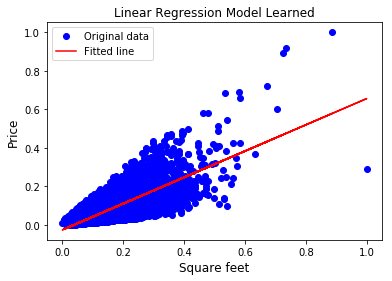

In [110]:
# Evaluate our Model on the full dataset
tensor = torch.from_numpy(data.sqft_living.values).type(float_tensor).view(-1,1)
predicted = model(torch.autograd.Variable(tensor)).data.numpy()

# Plot the graph
plt.plot(data.sqft_living, data.price, 'bo', label='Original data')
plt.plot(data.sqft_living, predicted, 'r-', label='Fitted line')
plt.ylabel('Price', fontsize=12)
plt.xlabel('Square feet', fontsize=12)
plt.title("Linear Regression Model Learned")
plt.legend()
plt.show()

Excellent! But wait, we have not learned so much! Yes indeed, this is not a good model and it was obvius since the beginning that a line could not fit a similar distribution. We need deeper or powerful model capable to learn more than a single line.

## What if we have more features?

We have covered a linear model based on only the square feet living feature, but we know that the price is a function of different features, what do we need to do if we want to include additional features and try to predict the price with a Linear Model in this regression Task? 

Now we have a new feature and we will see how to change the model according to this changing.

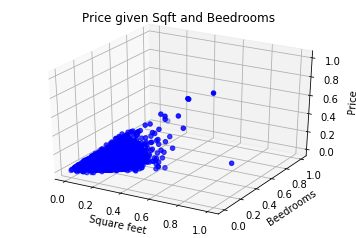

In [120]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# # Axes3D.scatter(xs, ys, zs=0, zdir='z', s=20, c=None, depthshade=True,)
data['price'] = dataset_normalization(data['price'])
data['sqft_living'] = dataset_normalization(data['sqft_living'])
data['bedrooms'] = dataset_normalization(data['bedrooms'])


ax.scatter(xs=data.sqft_living, ys=data.bedrooms, zs=data.price, c='b', marker='o')

ax.set_xlabel('Square feet')
ax.set_ylabel('Beedrooms')
ax.set_zlabel('Price')
plt.title("Price given Sqft and Beedrooms")
plt.show()

In [132]:
class Sqft2Price(Dataset):
    def __init__(self, start, end, normalize=False):
        self.data = pd.read_csv("/input/kc_house_data.csv")
        self.len = end
        if normalize:
            self.train = dataset_normalization(data[['sqft_living', 'bedrooms']][start:end].values)
            self.label = dataset_normalization(data['price'][start:end].values)
        else:
            self.train = data[['sqft_living', 'bedrooms']][start:end]
            self.label = data[['sqft_living', 'bedrooms']][start:end]
        
    def __getitem__(self, index):
        # Return (train_sample, labels)
        return (self.train[index], self.label[index])

    def __len__(self):
        return self.len # how many examples you have

# Compute 20% for dev/test split
val_test_split = ((21613 * 20 )//100)
# The remaining 60 is for training
train_split = len(data.index) - (val_test_split * 2)  

# Train Set Split %60  
train_set = Sqft2Price(0, train_split, normalize=True)
print ("Train Set starts: 0, end: ", train_split)
# Val Set Split %20
val_split = train_split + val_test_split
print ("Validation Set starts: ", train_split+1, ", end: ", train_split + val_test_split)
val_set = Sqft2Price(train_split+1, train_split + val_test_split, normalize=True)
# Test Set Split %20
print ("Test Set starts: ", val_split+1, ", end: ", len(data.index))
test_set = Sqft2Price(val_split+1, len(data.index), normalize=True)

Train Set starts: 0, end:  12969
Validation Set starts:  12970 , end:  17291
Test Set starts:  17292 , end:  21613


In [150]:
# Define the data Loader for Train, Val, Test
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [136]:
# Linear Regression Model
class LinearRegression(nn.Module):
    # Template for LR
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Define a Linear Model with 2 features(weights/variables), bias, and output a single number
# w1 * sqft + w2 * bedrooms + bias = price, we are learning the w1, w2 and bias
model = LinearRegression(input_size=2, output_size=1)

# If you are running a GPU instance, load the model on GPU
if cuda:
    model.cuda()

In [142]:
# Define SGD Optimizer
learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [149]:
# import torch.autograd.Variable as Variable

# Hyper Parameters
#input_size = 1
#output_size = 1
#learning_rate = 1e-5 # 0.00001
num_epochs = 2


# Train the Model 
for epoch in range(num_epochs):
    # Get batch from loader
    for i, (input, target) in enumerate(train_loader):
        #print (input.size()) 
        float_tensor = 'torch.FloatTensor'
        # Convert to FloatTensor then wrap as Variable
        input = torch.autograd.Variable(input.type(float_tensor))
        target = torch.autograd.Variable(target.type(float_tensor))
        # Load Variable on GPU
        if cuda:
            input, target = input.cuda(), target.cuda()
            
        # Forward + Backward + Optimize
        optimizer.zero_grad()  
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        # Load loss into CPU
        if cuda:
            loss.cpu()
    if (epoch+1) % 1 == 0:
        print ('Epoch [%d/%d], Loss: %.4f' 
               %(epoch+1, num_epochs, loss.data[0]))

Epoch [1/2], Loss: 0.1283
Epoch [2/2], Loss: 0.1270


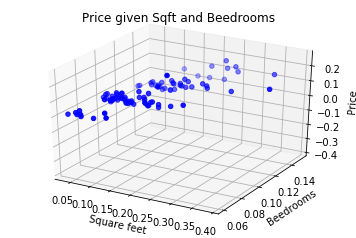

In [195]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Evaluate our Model on the full dataset
tensor = torch.from_numpy(data[['sqft_living', 'bedrooms']].values[:100]).type(float_tensor)
predicted = model(torch.autograd.Variable(tensor)).data.numpy()

# Normalization
data['price'] = dataset_normalization(data['price'])
data['sqft_living'] = dataset_normalization(data['sqft_living'])
data['bedrooms'] = dataset_normalization(data['bedrooms'])

# Plot and Scatter
ax.scatter(xs=data.sqft_living[:100], ys=data.bedrooms[:100], zs=data.price[:100], c='b', marker='o')
ax.plot_surface(X=data.sqft_living.values[:100], Y=data.bedrooms.values[:100], Z=predicted.ravel(), color='None')

ax.set_xlabel('Square feet')
ax.set_ylabel('Beedrooms')
ax.set_zlabel('Price')
plt.title("Price given Sqft and Beedrooms")
plt.show()

## Do you want more?

In the next step we will move to another great classical of ML: the handwritten digit classifiaction task of MNIST dataset. We will cover another simple model (Logistic Regression) that we will "evolve"(Neural Networks) until reaching state-of-the-art model(Convolutional Neural Network) on this task and familiarize with PyTorch and the Deep Learning Framework.

## Summary

After this brief and high level introduction to Machine Learning and its workflow you have a developed a basic understanding about what ML is and in which way we can learn from data. But repeat everything one more time can only help us to fix this new knowledge, this is what we have learned:

- The First question every Data Scientist need to face is: Where Can I find the data usefull for my task?
- The next step is to create a data pipeline, in the previous example, we have defined a custom Dataset in which we have defined the train/dev/test split, then we have normalize our data for numerical stability. 
- Once we have defined our dataset, we have build our Linear Model class inherited from the pytorch.nn module, according to the features and output we have to compute.
- A loss function and Optimizer are the last things to define before begin the training process
- In the training process we have wrapped all the pieces to learn a good model which can generalize on new data
- The evaluation process we are testing what our model have learned. Now we can make assumption and consideration abou the next experiment to run

## It's you turn!

Now it's your turn to test what you have learned on new knowledge: explore the dataset or take a new one, change hyperparamters, hack the linear model, explore new loss functions, try othera optimizera or if you are eager to learn, What are you expecting to move on the next part of the beginner episode? ;)

## One More Thing

You have achieved the *Linear Model Trophy*, now you are able to run the Polynomial Regression Task(it's a Linear Model capable to fit a 4degree Polynomial). How a Linear Model can fit a 4degree pol? Because it's Linear in the weights! It's ok if you are a bit confused. Take your time to fix this knowledge trying this example it will fix in your mind.

[Jump to PyTorch Polynomial Regression example](https://github.com/floydhub/regression)

## Thanks and Resources

Big thanks to:
- ...

Resources:
- [the-gentlest-introduction-to-tensorflow](https://medium.com/all-of-us-are-belong-to-machines/the-gentlest-introduction-to-tensorflow-248dc871a224)
- [yunjey-pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial)
- [house-price-prediction, which have inspired me about use king county kaggle dataset](https://github.com/Shreyas3108/house-price-prediction/blob/master/housesales.ipynb)
- [pyTorch custom dataset example](https://github.com/utkuozbulak/pytorch-custom-dataset-examples)